In [ ]:
"""
CV Duty-Class Data Preparation Pipeline
"""

from pathlib import Path
import argparse
import logging
import sys
import pandas as pd
import numpy as np


# --------------------
# Logging
# --------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
)
log = logging.getLogger(__name__)


# --------------------
# Constants
# --------------------
DEFAULT_SPLIT = {"share_ld": 0.55, "share_md": 0.25, "share_hd": 0.20}

OICA_IN = "oica_cv_sales_input.csv"
FUEL_IN = "fuel_prices_input.csv"
MACRO_IN = "macro_indicators_input.csv"


# --------------------
# Helpers
# --------------------
def ensure_dirs(*paths):
    for p in paths:
        p.mkdir(parents=True, exist_ok=True)


def standardize_country(df):
    mapping = {
        "UAE": "United Arab Emirates",
        "KSA": "Saudi Arabia",
        "Viet Nam": "Vietnam",
    }
    df["country"] = df["country"].astype(str).str.strip().replace(mapping)
    return df


def interpolate(df, cols):
    df = df.sort_values(["country", "year"])
    df[cols] = (
        df.groupby("country")[cols]
        .apply(lambda g: g.interpolate(limit_direction="both"))
        .reset_index(level=0, drop=True)
    )
    return df


def add_lags(df):
    df = df.sort_values(["country", "year"]).copy()
    num_cols = df.select_dtypes(include=[np.number]).columns
    for c in num_cols:
        df[f"{c}_lag1"] = df.groupby("country")[c].shift(1)
    return df.dropna().reset_index(drop=True)


# --------------------
# Templates
# --------------------
def create_templates(raw_input):
    ensure_dirs(raw_input)

    templates = {
        OICA_IN: "country,year,cv_total\nIndia,2020,750000\nIndia,2021,820000\n",
        FUEL_IN: "country,year,fuel_price\nIndia,2020,0.95\nIndia,2021,1.02\n",
        MACRO_IN: "country,year,gdp_growth,industrial_production\nIndia,2020,-7.3,-5\nIndia,2021,8.7,6.5\n",
    }

    created = False
    for name, content in templates.items():
        path = raw_input / name
        if not path.exists():
            path.write_text(content)
            log.warning(f"Template created: {path}")
            created = True

    if created:
        log.warning("Fill templates and re-run.")
    return created


# --------------------
# Main Pipeline
# --------------------
def prepare_data(base_dir: Path):
    raw_input = base_dir / "data" / "raw_input"
    raw_out = base_dir / "data" / "raw"
    processed = base_dir / "data" / "processed"

    ensure_dirs(raw_input, raw_out, processed)

    if create_templates(raw_input):
        return

    oica = pd.read_csv(raw_input / OICA_IN)
    fuel = pd.read_csv(raw_input / FUEL_IN)
    macro = pd.read_csv(raw_input / MACRO_IN)

    oica = standardize_country(oica)
    fuel = standardize_country(fuel)
    macro = standardize_country(macro)

    for df in [oica, fuel, macro]:
        df["year"] = df["year"].astype(int)

    oica["cv_total"] = pd.to_numeric(oica["cv_total"], errors="coerce")
    fuel["fuel_price"] = pd.to_numeric(fuel["fuel_price"], errors="coerce")
    macro[["gdp_growth", "industrial_production"]] = macro[
        ["gdp_growth", "industrial_production"]
    ].apply(pd.to_numeric, errors="coerce")

    oica = interpolate(oica, ["cv_total"])
    fuel = interpolate(fuel, ["fuel_price"])
    macro = interpolate(macro, ["gdp_growth", "industrial_production"])

    # Duty split
    oica["volume_ld"] = oica["cv_total"] * DEFAULT_SPLIT["share_ld"]
    oica["volume_md"] = oica["cv_total"] * DEFAULT_SPLIT["share_md"]
    oica["volume_hd"] = oica["cv_total"] * DEFAULT_SPLIT["share_hd"]

    panel = (
        oica.merge(fuel, on=["country", "year"], how="left")
            .merge(macro, on=["country", "year"], how="left")
    )

    panel = add_lags(panel)

    oica.to_csv(raw_out / "oica_cv_sales.csv", index=False)
    fuel.to_csv(raw_out / "fuel_prices_worldbank.csv", index=False)
    macro.to_csv(raw_out / "macro_indicators.csv", index=False)
    panel.to_csv(processed / "panel_dataset_processed.csv", index=False)

    log.info("✅ Pipeline completed successfully")


# --------------------
# Entry Point
# --------------------
def main():
    if "ipykernel" in sys.argv[0]:
        log.info("Running in Jupyter mode")
        prepare_data(Path("."))
    else:
        parser = argparse.ArgumentParser()
        parser.add_argument("--base_dir", default=".")
        args = parser.parse_args()
        prepare_data(Path(args.base_dir))


if __name__ == "__main__":
    main()


# EXPLORATORY DATA ANALYSIS (EDA)

In [3]:
import pandas as pd
from pathlib import Path

file_path = Path("data") / "processed" / "panel_dataset_processed.csv"

if not file_path.exists():
    raise FileNotFoundError(
        "Processed dataset not found. Please re-run the data preparation pipeline."
    )

df = pd.read_csv(file_path)
df.head()


C:\Users\hp\Documents\anaconda3_new\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\hp\Documents\anaconda3_new\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,country,year,cv_total,volume_ld,volume_md,volume_hd,fuel_price,gdp_growth,industrial_production,year_lag1,cv_total_lag1,volume_ld_lag1,volume_md_lag1,volume_hd_lag1,fuel_price_lag1,gdp_growth_lag1,industrial_production_lag1
0,India,2021,820000,451000.0,205000.0,164000.0,1.02,8.7,6.5,2020.0,750000.0,412500.0,187500.0,150000.0,0.95,-7.3,-5.0
1,India,2022,900000,495000.0,225000.0,180000.0,1.15,7.0,5.2,2021.0,820000.0,451000.0,205000.0,164000.0,1.02,8.7,6.5
2,Japan,2021,450000,247500.0,112500.0,90000.0,1.25,1.7,2.1,2020.0,420000.0,231000.0,105000.0,84000.0,1.20,-4.3,-3.8
3,Japan,2022,480000,264000.0,120000.0,96000.0,1.30,1.0,1.5,2021.0,450000.0,247500.0,112500.0,90000.0,1.25,1.7,2.1


In [4]:
df.shape


(4, 17)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     4 non-null      object 
 1   year                        4 non-null      int64  
 2   cv_total                    4 non-null      int64  
 3   volume_ld                   4 non-null      float64
 4   volume_md                   4 non-null      float64
 5   volume_hd                   4 non-null      float64
 6   fuel_price                  4 non-null      float64
 7   gdp_growth                  4 non-null      float64
 8   industrial_production       4 non-null      float64
 9   year_lag1                   4 non-null      float64
 10  cv_total_lag1               4 non-null      float64
 11  volume_ld_lag1              4 non-null      float64
 12  volume_md_lag1              4 non-null      float64
 13  volume_hd_lag1              4 non-null 

In [6]:
df.describe()


,year,cv_total,volume_ld,volume_md,volume_hd,fuel_price,gdp_growth,industrial_production,year_lag1,cv_total_lag1,volume_ld_lag1,volume_md_lag1,volume_hd_lag1,fuel_price_lag1,gdp_growth_lag1,industrial_production_lag1
count,4.00000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,2021.50000,662500.000000,364375.000000,165625.000000,132500.00000,1.180000,4.600000,3.825000,2020.50000,610000.000000,335500.000000,152500.000000,122000.000000,1.105000,-0.300000,-0.050000
std,0.57735,230705.439901,126887.991946,57676.359975,46141.08798,0.123558,3.827096,2.410221,0.57735,204450.483003,112447.765651,51112.620751,40890.096601,0.142945,7.071068,5.356927
min,2021.00000,450000.000000,247500.000000,112500.000000,90000.00000,1.020000,1.000000,1.500000,2020.00000,420000.000000,231000.000000,105000.000000,84000.000000,0.950000,-7.300000,-5.000000
25%,2021.00000,472500.000000,259875.000000,118125.000000,94500.00000,1.117500,1.525000,1.950000,2020.00000,442500.000000,243375.000000,110625.000000,88500.000000,1.002500,-5.050000,-4.100000
50%,2021.50000,650000.000000,357500.000000,162500.000000,130000.00000,1.200000,4.350000,3.650000,2020.50000,600000.000000,330000.000000,150000.000000,120000.000000,1.110000,-1.300000,-0.850000
75%,2022.00000,840000.000000,462000.000000,210000.000000,168000.00000,1.262500,7.425000,5.525000,2021.00000,767500.000000,422125.000000,191875.000000,153500.000000,1.212500,3.450000,3.200000
max,2022.00000,900000.000000,495000.000000,225000.000000,180000.00000,1.300000,8.700000,6.500000,2021.00000,820000.000000,451000.000000,205000.000000,164000.000000,1.250000,8.700000,6.500000


In [7]:
df.isna().sum()


country                       0
year                          0
cv_total                      0
volume_ld                     0
volume_md                     0
volume_hd                     0
fuel_price                    0
gdp_growth                    0
industrial_production         0
year_lag1                     0
cv_total_lag1                 0
volume_ld_lag1                0
volume_md_lag1                0
volume_hd_lag1                0
fuel_price_lag1               0
gdp_growth_lag1               0
industrial_production_lag1    0
dtype: int64

## CV trend with country

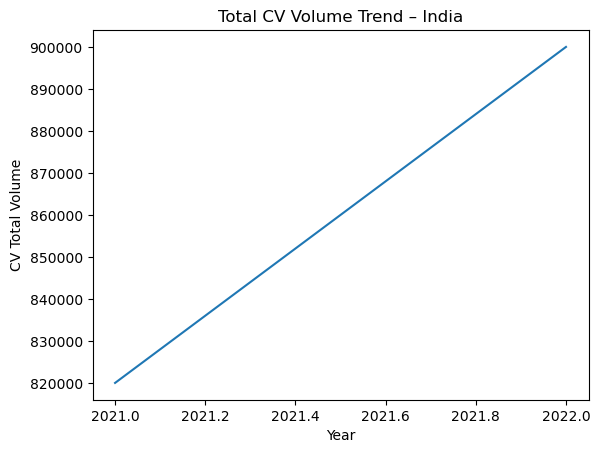

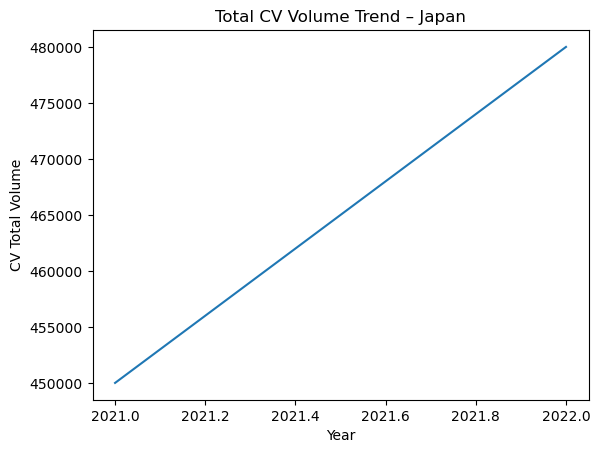

In [8]:
import matplotlib.pyplot as plt

for country in df["country"].unique():
    subset = df[df["country"] == country]
    plt.figure()
    plt.plot(subset["year"], subset["cv_total"])
    plt.title(f"Total CV Volume Trend – {country}")
    plt.xlabel("Year")
    plt.ylabel("CV Total Volume")
    plt.show()


## insight : Shows demand growth but decline patterns

# Duty-Class Split (LD / MD / HD)

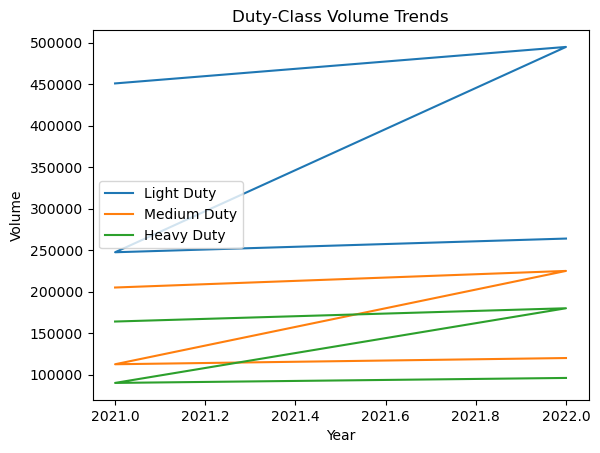

In [9]:
plt.figure()
plt.plot(df["year"], df["volume_ld"], label="Light Duty")
plt.plot(df["year"], df["volume_md"], label="Medium Duty")
plt.plot(df["year"], df["volume_hd"], label="Heavy Duty")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Volume")
plt.title("Duty-Class Volume Trends")
plt.show()


## Insight : Shows HD market moving towards MD but LD no impact

# Fuel Price vs CV Demand

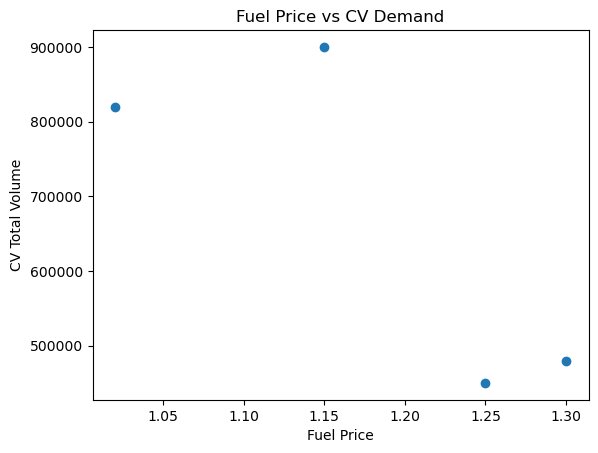

In [10]:
plt.figure()
plt.scatter(df["fuel_price"], df["cv_total"])
plt.xlabel("Fuel Price")
plt.ylabel("CV Total Volume")
plt.title("Fuel Price vs CV Demand")
plt.show()


## Insight : very much sensitive to fuel price impact the volume 

# GDP Growth vs CV Demand

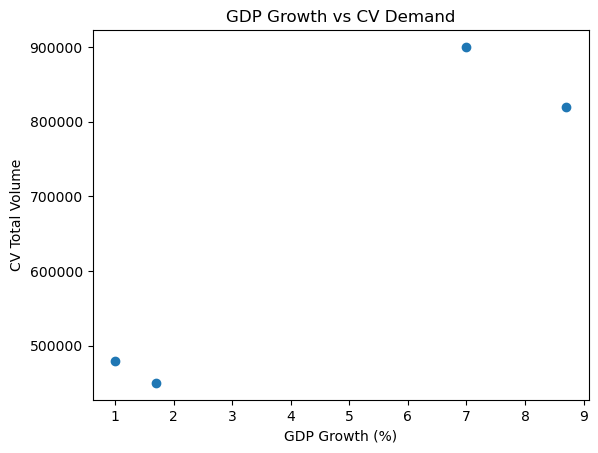

In [11]:
plt.figure()
plt.scatter(df["gdp_growth"], df["cv_total"])
plt.xlabel("GDP Growth (%)")
plt.ylabel("CV Total Volume")
plt.title("GDP Growth vs CV Demand")
plt.show()


## Insight : As GDP chagnes volume impacted  

## Correlation Heatmap

In [14]:
import seaborn as sns

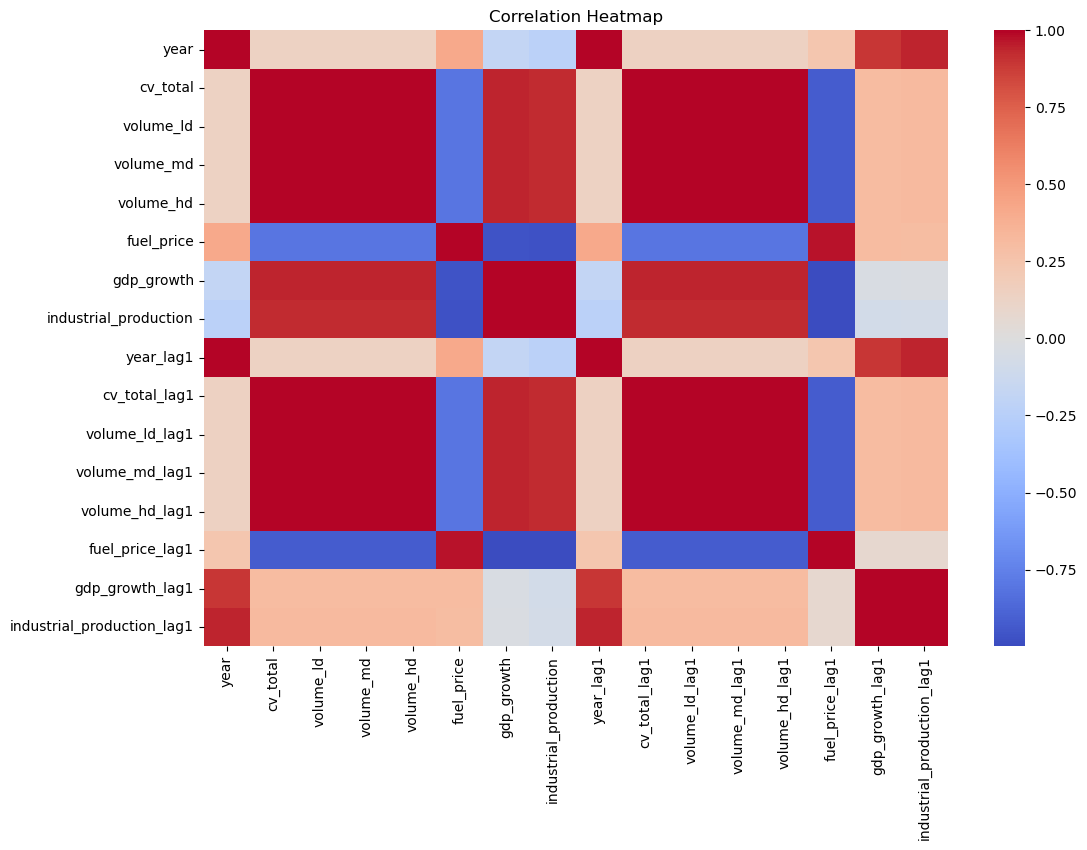

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(),
cmap="coolwarm",
annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [31]:
country_name = df["country"].iloc[0]

ts = (
    df[df["country"] == country_name]
    .sort_values("year")
    .set_index("year")["cv_total"]
)


## Train/Test split

In [32]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]


## ARIMA model

In [33]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1,1,1))
fitted = model.fit()

forecast = fitted.forecast(steps=len(test))


C:\Users\hp\Documents\anaconda3_new\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\Documents\anaconda3_new\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\Documents\anaconda3_new\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\Documents\anaconda3_new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\hp\Documents\anaconda3_new\lib\site-p

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("ARIMA MAE:", mae)
print("ARIMA RMSE:", rmse)


ARIMA MAE: 79999.99999999988
ARIMA RMSE: 79999.99999999988


## Evaluation

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("ARIMA MAE:", mae)
print("ARIMA RMSE:", rmse)


ARIMA MAE: 79999.99999999988
ARIMA RMSE: 79999.99999999988
